# To Do List:

### Main Plan
- Linking TDC info for tomo
    - correct existing
    - get ortho coordinate and generate tomo
- tomogram generation through diffTDC data
- Cuts on temporal space
- Clean report ready with 2D histo + resolution val

### Later
- RL work with Cris
- study of factors affecting tomogram generation
- tomogram using discrete angle binned data
- tomogram visualization
- ML applications
- Resolution determination
- Better Muon Track Reco algorithms 

## Tomogram Generation

Testing of new equations.

Zplane of T1 and T2 are defined to be $0$ while that of T3 and T4 are defined to be $-d_{sep}$. Zplane of bricks are $d_{brick}$.

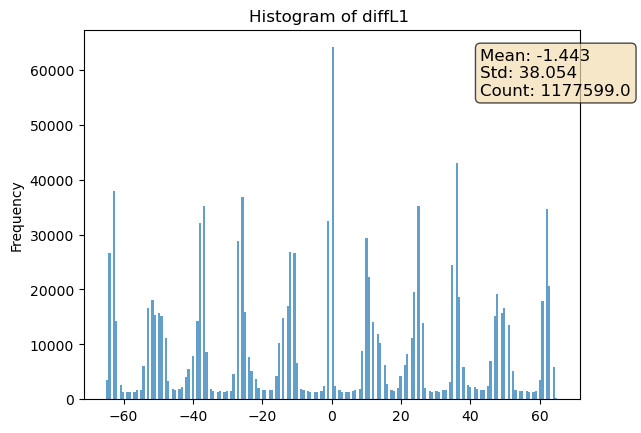

In [22]:
mdfo_calib.reload()
mdfo_calib.getHistogram("diffL1",range=(-65,65))

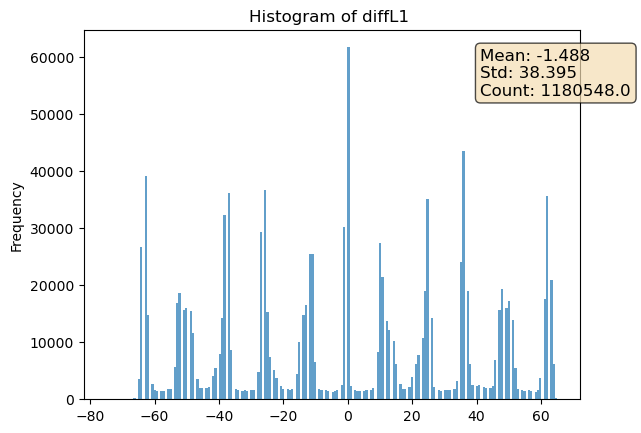

In [25]:
mdfo_lead.reload()
mdfo_lead.getHistogram("diffL1",range=(-75,65))

In [1]:
def getPhysicalUnits(asym):
    return (55 / 0.6) * asym


def getPhysicalUnitsFromDiffTDC(tdc):
    return (55 / 130) * tdc


def getPhysicalUnitsFromSumTDC(tdc, diff):
    return (60 / diff) * tdc


def getXatZPlane(x1, x2, zplane, dsep):
    x = (zplane / dsep) * (getPhysicalUnits(x1) -
                           getPhysicalUnits(x2)) + getPhysicalUnits(x1)
    return x


def getBoundaryValues(mdfo,term, num):
    stats = mdfo.events_df[term].describe()
    std = stats[2]
    return num*std


def getXatZPlane_sumTDC(mdfo, x1, x2, zplane, dsep, num=6):
    diff1 = getBoundaryValues(mdfo, x1, num)
    diff2 = getBoundaryValues(mdfo, x2, num)
    x1 = mdfo.get(x1)
    x2 = mdfo.get(x2)
    print("diff1: ", diff1, "\ndiff2: ", diff2)
    x = (zplane / dsep) * (getPhysicalUnitsFromSumTDC(x1, diff1) -
                           getPhysicalUnitsFromSumTDC(x2, diff2)
                           ) + getPhysicalUnitsFromSumTDC(x1, diff1)
    return x


def getXatZPlane_diffTDC(x1, x2, zplane, dsep):
    x = (zplane / dsep) * (
        getPhysicalUnitsFromDiffTDC(x1) -
        getPhysicalUnitsFromDiffTDC(x2)) + getPhysicalUnitsFromDiffTDC(x1)
    return x

In [2]:
import scipy.interpolate, scipy.optimize


def getLeadDistanceinXArr(xx_lead, xx_calib, bins):
    b1 = plt.hist(xx_lead, bins=bins, density=True, range=(-50, 50))
    b2 = plt.hist(xx_calib, bins=bins, density=True, range=(-50, 50))
    x = np.array([i * 5 for i in range(1, 12)])
    y1 = [1 for i in range(len(x))]
    y2 = b1[0] / b2[0]
    interp1 = scipy.interpolate.InterpolatedUnivariateSpline(x, y1)
    interp2 = scipy.interpolate.InterpolatedUnivariateSpline(x, y2)
    new_x = np.linspace(x.min(), x.max(), 100)
    new_y1 = interp1(new_x)
    new_y2 = interp2(new_x)
    idx = np.argwhere(np.diff(np.sign(new_y1 - new_y2)) != 0)

    plt.plot(x, y1, marker='o', mec='none', ms=4, lw=1, label='y1')
    plt.plot(x, y2, marker='o', mec='none', ms=4, lw=1, label='y2')
    plt.plot(new_x[idx], new_y1[idx], 'ro', ms=7, label='intersection')
    plt.legend(frameon=False, fontsize=10, numpoints=1, loc='lower left')
    plt.ylim(0.7, 1.05)
    plt.xlim(0, 60)
    plt.show()
    return list(new_x[idx])

In [3]:
def testTomogram(mdfo_lead,mdfo_calib,bins):
    xx_lead = mdfo_lead.get("xx")
    yy_lead = mdfo_lead.get("yy")
    xx_calib = mdfo_calib.get("xx")
    yy_calib = mdfo_calib.get("yy")
    b1 =plt.hist(xx_lead,bins=bins,alpha=1,label="Brick",density=True,range=(-50,50),histtype='step')
    b2 =plt.hist(xx_calib,bins=bins,alpha=1,label="Calib",density=True,range=(-50,50),histtype='step')
    plt.title("XView at ZPlane of Lead Brick (cm)")
    plt.legend()
    plt.show()
    b3 =plt.hist(yy_lead,bins=bins,alpha=1,label="Brick",density=True,range=(-50,50),histtype='step')
    b4 =plt.hist(yy_calib,bins=bins,alpha=1,label="Calib",density=True,range=(-50,50),histtype='step')
    plt.title("YView at ZPlane of Lead Brick (cm)")
    plt.legend()
    plt.show()
    plt.plot([i*5 for i in range(1,12)], (b1[0]/b2[0]),'--x',label = "X")
    plt.plot([i*5 for i in range(1,12)], (b3[0]/b4[0]),'--x',label = "Y")
    plt.axhline(y=1, color='r')
    plt.title("Ratio Plot")
    plt.xlabel("length (cm)")
    plt.grid()
    plt.legend()
    plt.ylim(0.85,1.1)
    plt.xlim(5,60)
    plt.show()
    #x_dist = getLeadDistanceinXArr(xx_lead,xx_calib,bins=11)
    #y_dist = getLeadDistanceinXArr(yy_lead,yy_calib,bins=11)    
    #return x_dist,y_dist

In [4]:
def testTomogramRaw(mdfo_lead,mdfo_calib,bins):
    xx_lead = mdfo_lead.get("xx")
    yy_lead = mdfo_lead.get("yy")
    xx_calib = mdfo_calib.get("xx")
    yy_calib = mdfo_calib.get("yy")
    b1 =plt.hist(xx_lead,bins=bins,alpha=1,label="Brick",range=(-50,50),histtype='step')
    b2 =plt.hist(xx_calib,bins=bins,alpha=1,label="Calib",range=(-50,50),histtype='step')
    plt.title("XView at ZPlane of Lead Brick (cm)")
    plt.legend()
    plt.show()
    b3 =plt.hist(yy_lead,bins=bins,alpha=1,label="Brick",range=(-50,50),histtype='step')
    b4 =plt.hist(yy_calib,bins=bins,alpha=1,label="Calib",range=(-50,50),histtype='step')
    plt.title("YView at ZPlane of Lead Brick (cm)")
    plt.legend()
    plt.show()
    plt.plot([i*5 for i in range(1,12)], (b1[0]/b2[0]),'--x',label = "X")
    plt.plot([i*5 for i in range(1,12)], (b3[0]/b4[0]),'--x',label = "Y")
    plt.axhline(y=1, color='r')
    plt.title("Ratio Plot")
    plt.xlabel("length (cm)")
    plt.grid()
    plt.legend()
    plt.ylim(0.85,1.1)
    plt.xlim(5,60)
    plt.show()
    #x_dist = getLeadDistanceinXArr(xx_lead,xx_calib,bins=11)
    #y_dist = getLeadDistanceinXArr(yy_lead,yy_calib,bins=11)    
    #return x_dist,y_dist

In [12]:
import copy

def getSameShapeDataSets(mdfo1, mdfo2):
    mdfo1 =  copy.copy(mdfo1)
    mdfo2 = copy.copy(mdfo2)
    s1 = len(mdfo1.events_df.index)
    s2 = len(mdfo2.events_df.index)
    s = min(s1,s2)
    mdfo1.events_df =  mdfo1.events_df.iloc[:s]
    mdfo2.events_df =  mdfo2.events_df.iloc[:s]
    return mdfo1, mdfo2

def getSameSizeData(mdfo1, mdfo2, data_term):
    mdfo1, mdfo2 = getSameShapeDataSets(mdfo1, mdfo2)
    return mdfo1.get(data_term), mdfo2.get(data_term)

def getRatioPlot( xviews, yviews, axes=[-40,40], bins=(15,15)):
    xx_lead, xx_calib = xviews
    yy_lead, yy_calib = yviews
    ranges = (axes,axes)
    h1, xedges, yedges = np.histogram2d(xx_lead, yy_lead, bins=bins, range=ranges)
    h2, xedges, yedges = np.histogram2d(xx_calib, yy_calib, bins=bins, range=ranges)
    h = h1 / h2
    h[h >= 1.12] = 1.12
   # h[h <= 0.7] = 0.7
    fig, ax = plt.subplots(1)
    pc = ax.pcolorfast(xedges, yedges, h.T)
    plt.title("Reco Z plane XY View Ratio (Data)",fontsize=15)
    plt.xlabel("X (cm)")
    plt.ylabel("Y (cm)")
    plt.colorbar(pc)
    plt.show()

In [6]:
import plotly.express as px

def doTomography(bins, mdf, title):
    fig = px.density_heatmap(mdf, x="xx", y="yy", title=title, nbinsx=bins, nbinsy=bins,
                             marginal_x="histogram", marginal_y="histogram")
    
    fig.update_layout(
    xaxis_title="XView (cm)",
    yaxis_title="YView (cm)",
    )
    fig.show()

---

# Loading Muon DataFrame Aggregate Data Files

In [7]:
import copy
from MuDataFrame import MuDataFrame

mdfo_calib = MuDataFrame("processed_data/calibration_data.csv")
mdfo_lead = MuDataFrame("processed_data/lead_data_updated.csv")

#mdfo_calib.events_df.drop(columns=["Unnamed: 0","index"],axis=1, inplace=True)
#mdfo_lead.events_df.drop(columns=["Unnamed: 0","index"],axis=1, inplace=True)

mdf_calib = mdfo_calib.events_df
mdf_lead = mdfo_lead.events_df

mdfo_calib.og_df = mdf_calib.copy()
mdfo_lead.og_df = mdf_lead.copy()

In [8]:
mdfo_calib.show()

,Unnamed: 0,event_num,event_time,deadtime,l1hit,l2hit,l3hit,l4hit,r1hit,r2hit,...,theta_x1,theta_y1,theta_x2,theta_y2,z_angle,SmallCounter,Run_Num,xx,yy,speed
0,0,0,0,0,1.0,1.0,1.0,1.0,1.0,1.0,...,22.205541,147.837258,-43.653927,-75.200711,6.371653,NaN,408,8.402778,8.285486,11.076032
1,1,1,94137,0,1.0,1.0,1.0,1.0,1.0,1.0,...,-201.513449,-16.290756,-236.082169,-13.905355,11.086497,NaN,408,-8.389304,29.851975,0.386791
2,2,2,259967,0,1.0,1.0,1.0,1.0,1.0,1.0,...,96.649159,33.966218,24.062017,136.431052,6.613531,NaN,408,-4.230215,-16.106861,0.277034
3,3,3,540068,0,1.0,1.0,1.0,1.0,1.0,1.0,...,14.648016,224.112695,24.072851,136.369656,11.331981,NaN,408,-29.130160,-7.886501,0.449059
4,4,4,650077,0,1.0,1.0,1.0,1.0,1.0,1.0,...,-260.859860,-12.584559,-23.756787,-138.183939,15.394396,NaN,408,12.760181,-29.695749,0.223868
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1299995,1299995,1299995,413012725545,0,1.0,1.0,1.0,0.0,1.0,1.0,...,-61.098818,-53.729457,NaN,NaN,NaN,NaN,436,11.709957,NaN,NaN
1299996,1299996,1299996,413012935812,0,1.0,1.0,1.0,0.0,1.0,1.0,...,306.891614,10.696957,NaN,NaN,NaN,NaN,436,-0.561640,NaN,NaN
1299997,1299997,1299997,413013055854,0,1.0,1.0,1.0,1.0,1.0,1.0,...,-0.920125,-3567.783279,56.221626,58.390455,6.169399,NaN,436,28.382114,-3.066643,0.345992
1299998,1299998,1299998,413013275834,0,1.0,1.0,0.0,0.0,1.0,1.0,...,366.200401,8.964508,NaN,NaN,NaN,NaN,436,NaN,NaN,NaN


In [9]:
mdfo_lead.show()

,Unnamed: 0,event_num,event_time,deadtime,l1hit,l2hit,l3hit,l4hit,r1hit,r2hit,...,theta_x1,theta_y1,theta_x2,theta_y2,z_angle,SmallCounter,Run_Num,xx,yy,speed
0,0,0,0,0,1,0,1,1,0,0,...,NaN,NaN,-24.429218,-134.380326,NaN,NaN,410,NaN,NaN,NaN
1,1,1,510238,0,1,1,1,0,1,1,...,-53.995476,-60.797804,NaN,NaN,NaN,NaN,410,14.764119,NaN,NaN
2,2,2,680128,0,1,1,1,1,1,1,...,43.369722,75.693507,-inf,-0.000000,6.464752,NaN,410,-18.990826,-14.251543,3.692686
3,3,3,1190113,0,1,1,1,0,1,1,...,2.446125,1342.043451,NaN,NaN,NaN,NaN,410,-13.148333,NaN,NaN
4,4,4,1500428,0,1,1,1,1,1,1,...,-4.959387,-661.937877,-18.455272,-177.879054,5.185096,NaN,410,6.296684,0.842881,2.763211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1299995,1299995,1299995,415072964999,0,1,1,1,1,1,1,...,-26.857397,-122.230996,-0.981846,-3343.503246,16.958188,NaN,422,-37.292360,14.723278,0.234857
1299996,1299996,1299996,415073134888,0,1,1,1,1,1,1,...,-73.405856,-44.721314,-41.120440,-79.833930,2.626992,NaN,422,-12.687742,19.308536,0.612178
1299997,1299997,1299997,415073565015,0,1,1,1,1,0,0,...,NaN,NaN,inf,0.000000,NaN,NaN,422,NaN,NaN,NaN
1299998,1299998,1299998,415073675247,0,1,1,1,0,1,1,...,116.753664,28.117373,NaN,NaN,NaN,NaN,422,-2.350427,NaN,NaN


# Assigning Speeds to Muon Hits

In [99]:
toSeconds = 0.000000001
tdcToNs = 0.5 #ns
c = 299792458 #m/s

def calcMuonSpeeds(mdfo,dsep=1.65):
    """
    arbitrarily choosing tray 1 and 3 and left cable for time calculations
    """
    angles = np.array(np.cos(mdfo.get("z_angle")*(np.pi/180)))
    d_mu = dsep/angles # m
    t1 = mdfo.get("L1") * tdcToNs
    t2 = mdfo.get("L3") * tdcToNs
    del_t = (t1 - t2)*toSeconds 
    speeds = (abs(d_mu / del_t))/c
    mdfo.events_df["speed"] = speeds
    return speeds

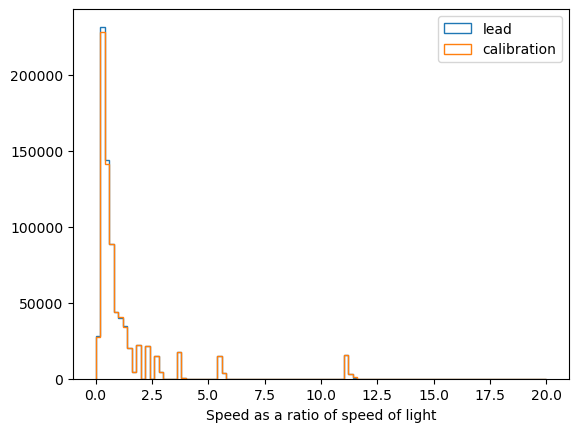

In [135]:
mdfo_lead.reload()
mdfo_lead.keep4by4Events()

mdfo_calib.reload()
mdfo_calib.keep4by4Events()


mu_speeds_lead = calcMuonSpeeds(mdfo_lead)
mu_speeds_calib = calcMuonSpeeds(mdfo_calib)


plt.hist(mu_speeds_lead,range=[0,20],bins=100, label="lead", histtype="step")
plt.hist(mu_speeds_calib,range=[0,20],bins=100, label="calibration", histtype="step")
plt.legend()
plt.xlabel("Speed as a ratio of speed of light")
plt.show()

# Tomogram Generation

Testing out different cuts

### All Data

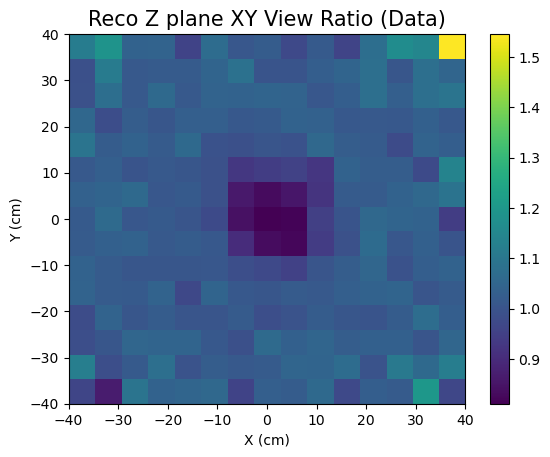

In [55]:
mdfo_lead.reload()

mdfo_calib.reload()

xx_lead, xx_calib = getSameSizeData(mdfo_lead, mdfo_calib, "xx")
yy_lead, yy_calib = getSameSizeData(mdfo_lead, mdfo_calib, "yy")

getRatioPlot([xx_lead,xx_calib],[yy_lead,yy_calib])

### 4/4 events

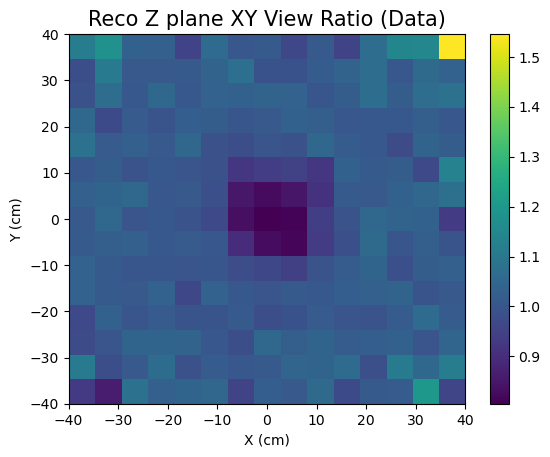

In [136]:
mdfo_lead.reload()
mdfo_lead.keep4by4Events()

mdfo_calib.reload()
mdfo_calib.keep4by4Events()

xx_lead, xx_calib = getSameSizeData(mdfo_lead, mdfo_calib, "xx")
yy_lead, yy_calib = getSameSizeData(mdfo_lead, mdfo_calib, "yy")

getRatioPlot([xx_lead,xx_calib],[yy_lead,yy_calib])

In [138]:
print("brick: ", len(mdfo_lead.events_df.index))
print("no brick: ", len(mdfo_calib.events_df.index))

brick:  766750
no brick:  761262


### Restricted Muon Angles

Angles less than 5 degrees

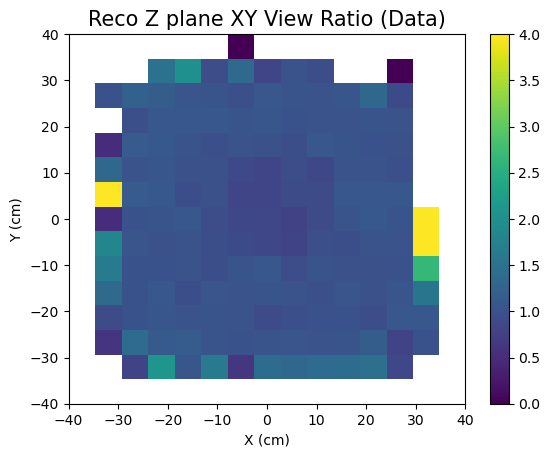

In [53]:
mdfo_lead.reload()
mdfo_lead.keep4by4Events()
mdfo_lead.keepEvents("z_angle", 5, "<=")


mdfo_calib.reload()
mdfo_calib.keep4by4Events()
mdfo_calib.keepEvents("z_angle", 5, "<=")


xx_lead, xx_calib = getSameSizeData(mdfo_lead, mdfo_calib, "xx")
yy_lead, yy_calib = getSameSizeData(mdfo_lead, mdfo_calib, "yy")

getRatioPlot([xx_lead,xx_calib],[yy_lead,yy_calib])

Angles between $[5,10]$ degrees

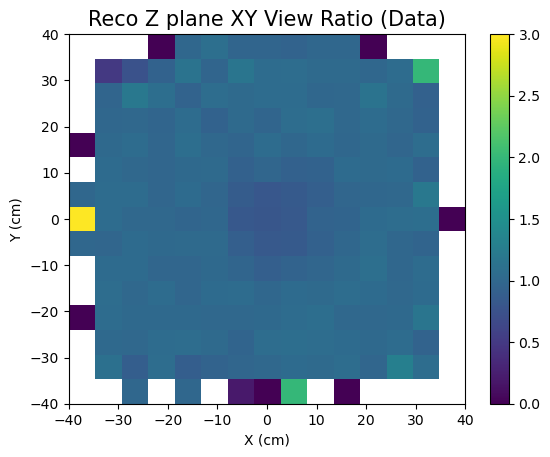

In [51]:
mdfo_lead.reload()
mdfo_lead.keep4by4Events()
mdfo_lead.keepEvents("z_angle", 5, ">=")
mdfo_lead.keepEvents("z_angle", 10, "<=")


mdfo_calib.reload()
mdfo_calib.keep4by4Events()
mdfo_calib.keepEvents("z_angle", 5, ">=")
mdfo_calib.keepEvents("z_angle", 10, "<=")



xx_lead, xx_calib = getSameSizeData(mdfo_lead, mdfo_calib, "xx")
yy_lead, yy_calib = getSameSizeData(mdfo_lead, mdfo_calib, "yy")

getRatioPlot([xx_lead,xx_calib],[yy_lead,yy_calib])

### Higher TDC Sums

<Figure size 640x480 with 0 Axes>

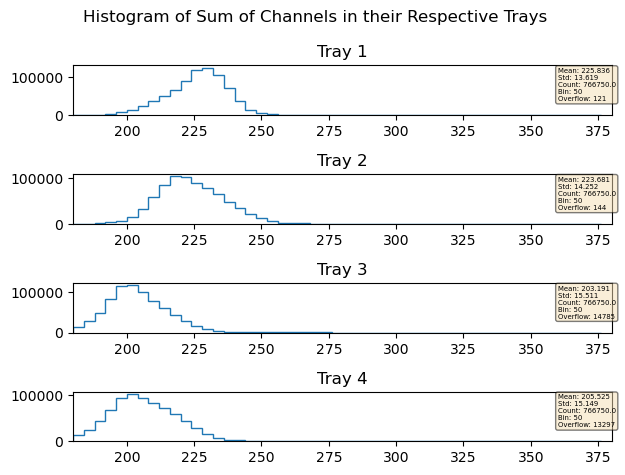

In [57]:
mdfo_lead.reload()
mdfo_lead.keep4by4Events()
mdfo_lead.getChannelSumPlots()

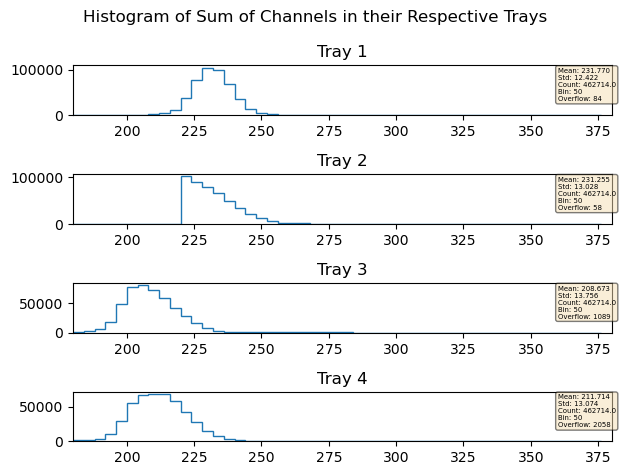

In [60]:
mdfo_lead.reload()
mdfo_lead.keep4by4Events()
mdfo_lead.keepEvents("sumL2",220,">=")
mdfo_lead.getChannelSumPlots()

Same for calibration data

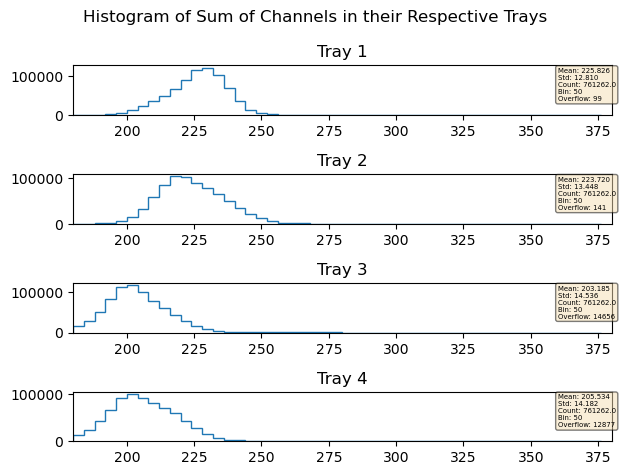

In [58]:
mdfo_calib.reload()
mdfo_calib.keep4by4Events()
mdfo_calib.getChannelSumPlots()

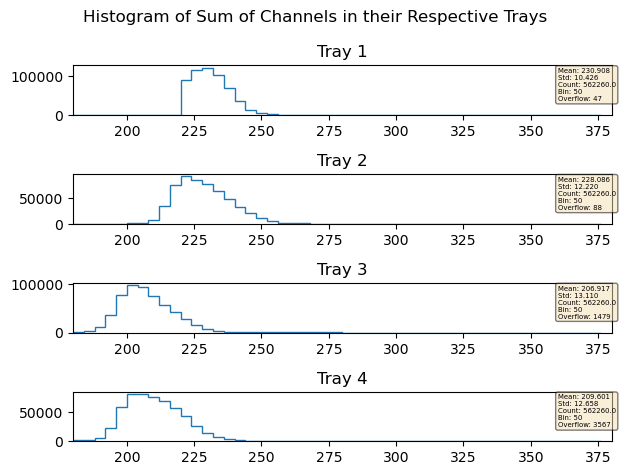

In [61]:
mdfo_calib.reload()
mdfo_calib.keep4by4Events()
mdfo_calib.keepEvents("sumL1",220,">=")
mdfo_calib.getChannelSumPlots()

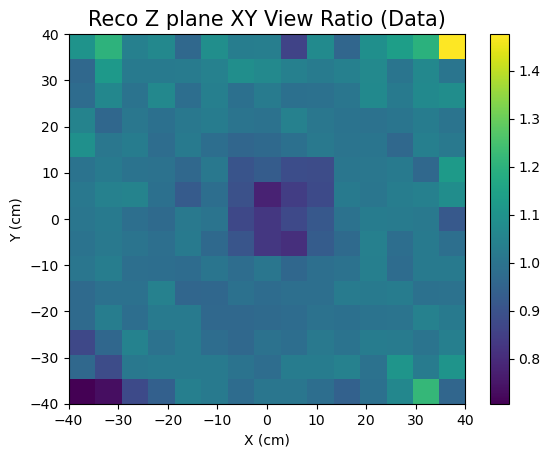

In [65]:
mdfo_lead.reload()
mdfo_lead.keep4by4Events()
mdfo_lead.keepEvents("sumL2",220,">=")

mdfo_calib.reload()
mdfo_calib.keep4by4Events()
mdfo_calib.keepEvents("sumL2",220,">=")


xx_lead, xx_calib = getSameSizeData(mdfo_lead, mdfo_calib, "xx")
yy_lead, yy_calib = getSameSizeData(mdfo_lead, mdfo_calib, "yy")

getRatioPlot([xx_lead,xx_calib],[yy_lead,yy_calib])

Conversely, if we do the opposite

### Low SumTDC Muons


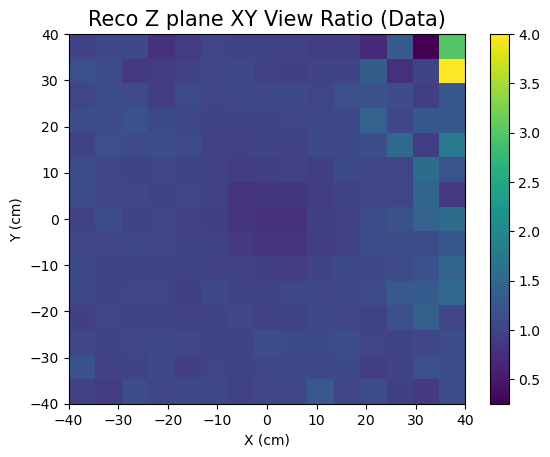

In [66]:
mdfo_lead.reload()
mdfo_lead.keep4by4Events()
mdfo_lead.keepEvents("sumL2",220,"<=")

mdfo_calib.reload()
mdfo_calib.keep4by4Events()
mdfo_calib.keepEvents("sumL2",220,"<=")


xx_lead, xx_calib = getSameSizeData(mdfo_lead, mdfo_calib, "xx")
yy_lead, yy_calib = getSameSizeData(mdfo_lead, mdfo_calib, "yy")

getRatioPlot([xx_lead,xx_calib],[yy_lead,yy_calib])

### Muons with sensible speeds (i.e. < c)

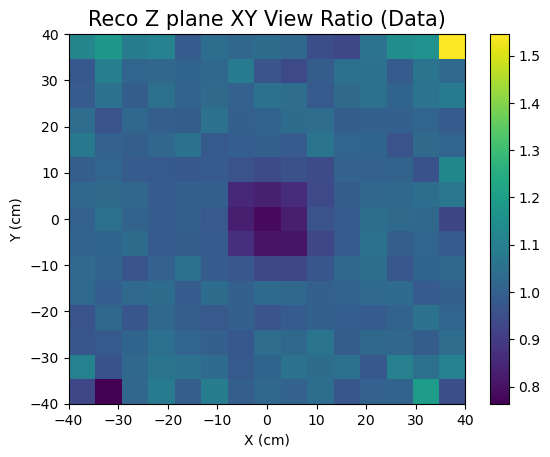

In [120]:
mdfo_lead.reload()
mdfo_lead.keep4by4Events()
mdfo_lead.keepEvents("speed",1,"<")

mdfo_calib.reload()
mdfo_calib.keep4by4Events()
mdfo_calib.keepEvents("speed",1,"<")


xx_lead, xx_calib = getSameSizeData(mdfo_lead, mdfo_calib, "xx")
yy_lead, yy_calib = getSameSizeData(mdfo_lead, mdfo_calib, "yy")

getRatioPlot([xx_lead,xx_calib],[yy_lead,yy_calib])

### Slower Muons

Keeping muons with speeds less than $0.6 c$

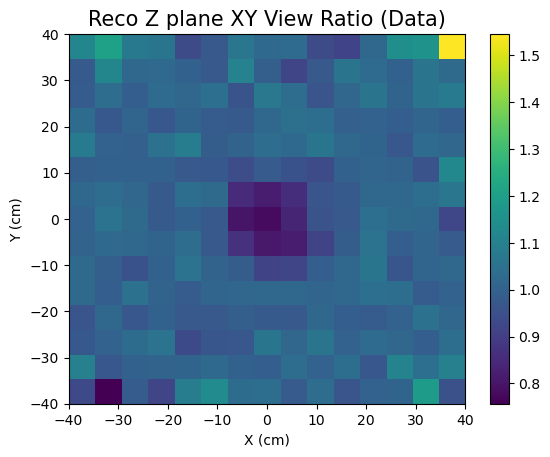

In [119]:
mdfo_lead.reload()
mdfo_lead.keep4by4Events()
mdfo_lead.keepEvents("speed",0.6,"<=")

mdfo_calib.reload()
mdfo_calib.keep4by4Events()
mdfo_calib.keepEvents("speed",0.6,"<=")


xx_lead, xx_calib = getSameSizeData(mdfo_lead, mdfo_calib, "xx")
yy_lead, yy_calib = getSameSizeData(mdfo_lead, mdfo_calib, "yy")

getRatioPlot([xx_lead,xx_calib],[yy_lead,yy_calib])

### Faster Muons

Keeping muons with speeds greater than $0.6 c$

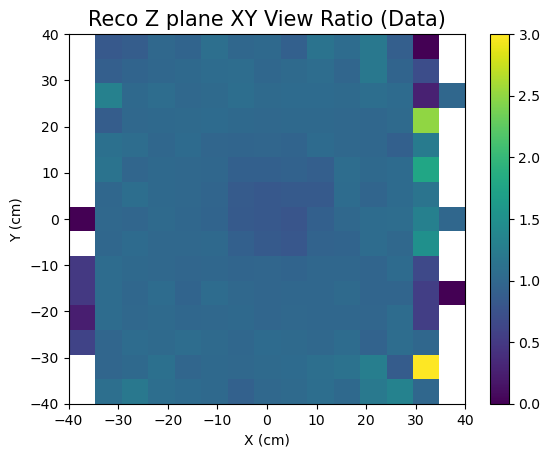

In [124]:
mdfo_lead.reload()
mdfo_lead.keep4by4Events()
mdfo_lead.keepEvents("speed",0.6,">=")

mdfo_calib.reload()
mdfo_calib.keep4by4Events()
mdfo_calib.keepEvents("speed",0.6,">=")


xx_lead, xx_calib = getSameSizeData(mdfo_lead, mdfo_calib, "xx")
yy_lead, yy_calib = getSameSizeData(mdfo_lead, mdfo_calib, "yy")

getRatioPlot([xx_lead,xx_calib],[yy_lead,yy_calib])

# Tomogram through Diff TDC

In [8]:
mdfo_calib.reload()
mdfo_lead.reload()

xx_lead = getXatZPlane_diffTDC(mdfo_lead.get("diffL1"), mdfo_lead.get("diffL3"), 42,
                       165)
yy_lead = getXatZPlane_diffTDC(mdfo_lead.get("diffL2"), mdfo_lead.get("diffL4"), 42,
                       165)
xx_calib = getXatZPlane_diffTDC(mdfo_calib.get("diffL1"), mdfo_calib.get("diffL3"), 42,
                        165)
yy_calib = getXatZPlane_diffTDC(mdfo_calib.get("diffL2"), mdfo_calib.get("diffL4"), 42,
                        165)

mdfo_lead.events_df["xx1"] = xx_lead
mdfo_lead.events_df["yy1"] = yy_lead

mdfo_calib.events_df["xx1"] = xx_calib
mdfo_calib.events_df["yy1"] = yy_calib

## Differences in the projected values

### Lead bricks case

In [50]:
x_diff = mdfo_lead.events_df["xx1"] - mdfo_lead.events_df["xx"]
y_diff = mdfo_lead.events_df["yy1"] - mdfo_lead.events_df["yy"]

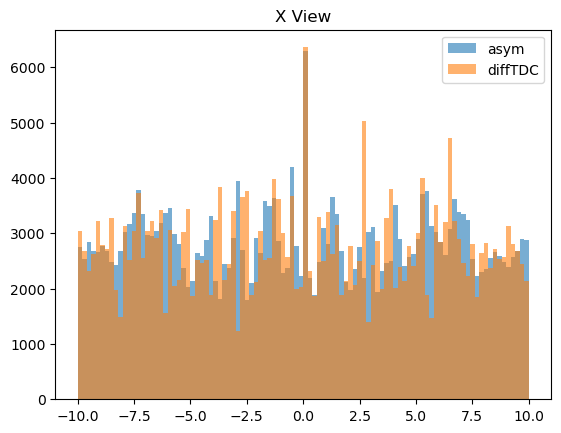

In [42]:
plt.title("X View")
plt.hist(mdfo_lead.events_df["xx"].values,range=(-10,10),bins=100,alpha=0.6,label="asym")
plt.hist(mdfo_lead.events_df["xx1"].values,range=(-10,10),bins=100,alpha=0.6,label="diffTDC")
plt.legend()
plt.show()

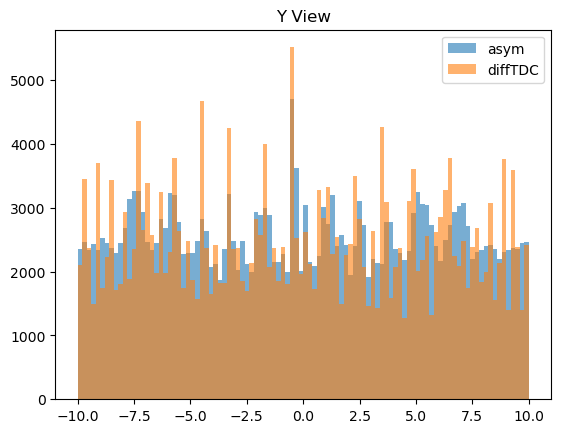

In [43]:
plt.title("Y View")
plt.hist(mdfo_lead.events_df["yy"].values,range=(-10,10),bins=100,alpha=0.6,label="asym")
plt.hist(mdfo_lead.events_df["yy1"].values,range=(-10,10),bins=100,alpha=0.6,label="diffTDC")
plt.legend()
plt.show()

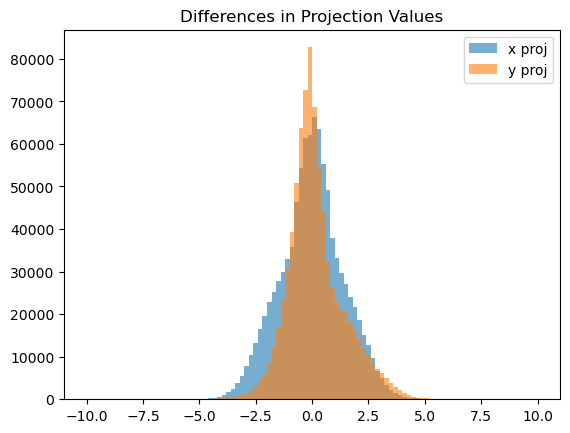

In [41]:
plt.title("Differences in Projection Values")
plt.hist(x_diff,range=(-10,10),bins=100,alpha=0.6,label="x proj")
plt.hist(y_diff,range=(-10,10),bins=100,alpha=0.6,label="y proj")
plt.legend()
plt.show()

### Calib Data Case

In [48]:
x_diff_c = mdfo_calib.events_df["xx1"] - mdfo_calib.events_df["xx"]
y_diff_c = mdfo_calib.events_df["yy1"] - mdfo_calib.events_df["yy"]

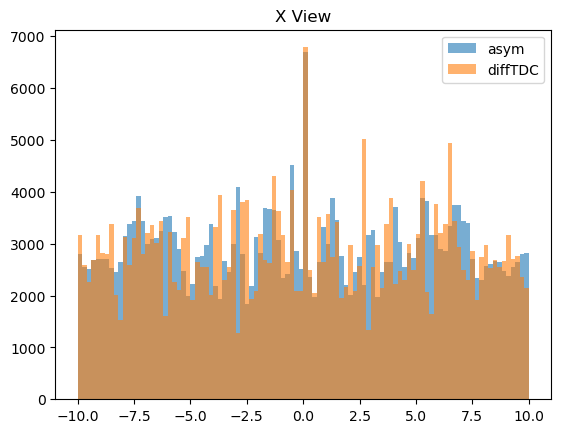

In [45]:
plt.title("X View")
plt.hist(mdfo_calib.events_df["xx"].values,range=(-10,10),bins=100,alpha=0.6,label="asym")
plt.hist(mdfo_calib.events_df["xx1"].values,range=(-10,10),bins=100,alpha=0.6,label="diffTDC")
plt.legend()
plt.show()

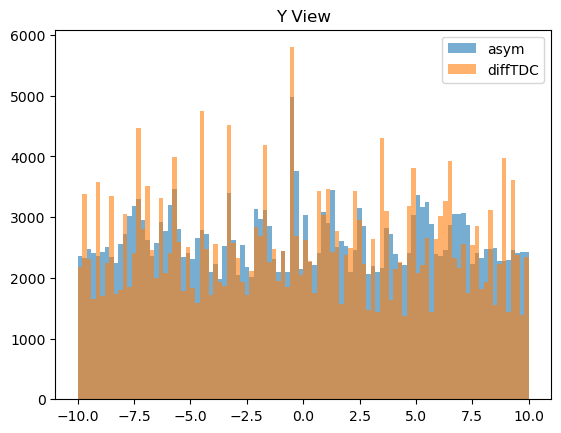

In [46]:
plt.title("Y View")
plt.hist(mdfo_calib.events_df["yy"].values,range=(-10,10),bins=100,alpha=0.6,label="asym")
plt.hist(mdfo_calib.events_df["yy1"].values,range=(-10,10),bins=100,alpha=0.6,label="diffTDC")
plt.legend()
plt.show()

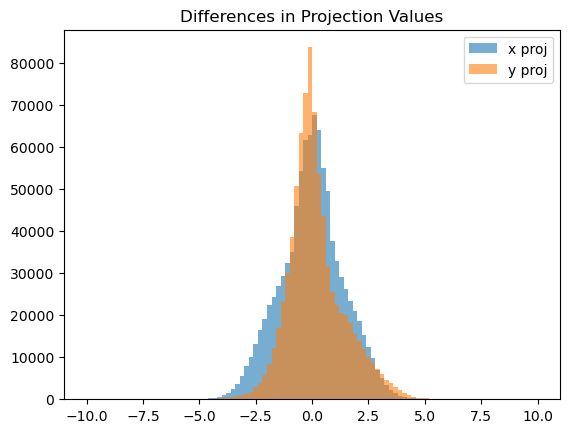

In [49]:
plt.title("Differences in Projection Values")
plt.hist(x_diff_c,range=(-10,10),bins=100,alpha=0.6,label="x proj")
plt.hist(y_diff_c,range=(-10,10),bins=100,alpha=0.6,label="y proj")
plt.legend()
plt.show()

### Looking at Differences

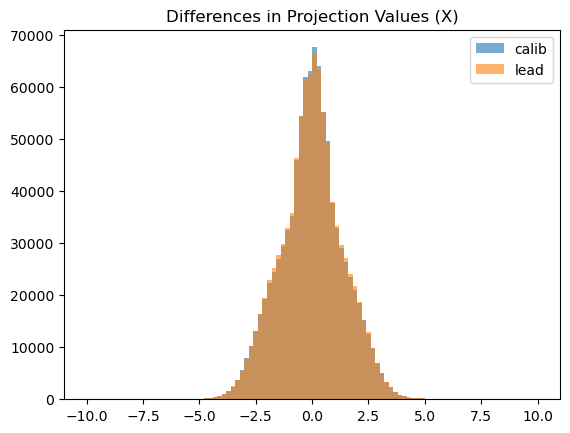

In [52]:
plt.title("Differences in Projection Values (X)")
plt.hist(x_diff_c,range=(-10,10),bins=100,alpha=0.6,label="calib")
plt.hist(x_diff,range=(-10,10),bins=100,alpha=0.6,label="lead")
plt.legend()
plt.show()

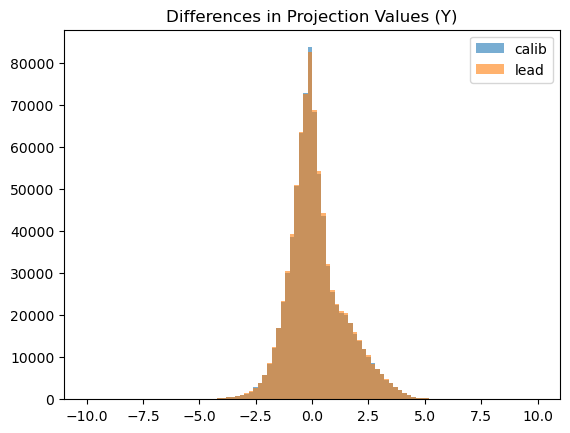

In [53]:
plt.title("Differences in Projection Values (Y)")
plt.hist(y_diff_c,range=(-10,10),bins=100,alpha=0.6,label="calib")
plt.hist(y_diff,range=(-10,10),bins=100,alpha=0.6,label="lead")
plt.legend()
plt.show()

## All Data

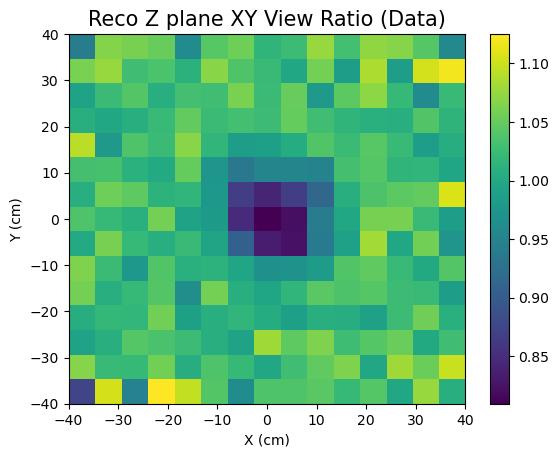

In [35]:
mdfo_lead.reload()

mdfo_calib.reload()

xx_lead, xx_calib = getSameSizeData(mdfo_lead, mdfo_calib, "xx1")
yy_lead, yy_calib = getSameSizeData(mdfo_lead, mdfo_calib, "yy1")

getRatioPlot([xx_lead,xx_calib],[yy_lead,yy_calib])

## 4/4 Events

In [ ]:
def getRatioPlot( xviews, yviews, axes=[-40,40], bins=(15,15)):
    xx_lead, xx_calib = xviews
    yy_lead, yy_calib = yviews
    ranges = (axes,axes)
    h1, xedges, yedges = np.histogram2d(xx_lead, yy_lead, bins=bins, range=ranges)
    h2, xedges, yedges = np.histogram2d(xx_calib, yy_calib, bins=bins, range=ranges)
    h = h1 / h2
    h[h >= 1.12] = 1.12
   # h[h <= 0.7] = 0.7
    fig, ax = plt.subplots(1)
    pc = ax.pcolorfast(xedges, yedges, h.T)
    plt.title("Reco Z plane XY View Ratio (Data)",fontsize=15)
    plt.xlabel("X (cm)")
    plt.ylabel("Y (cm)")
    plt.colorbar(pc)
    plt.show()

In [15]:
time = mdfo_lead.get("event_time")[-1]*0.00000000001157407
1.3/time

0.2706025728668466

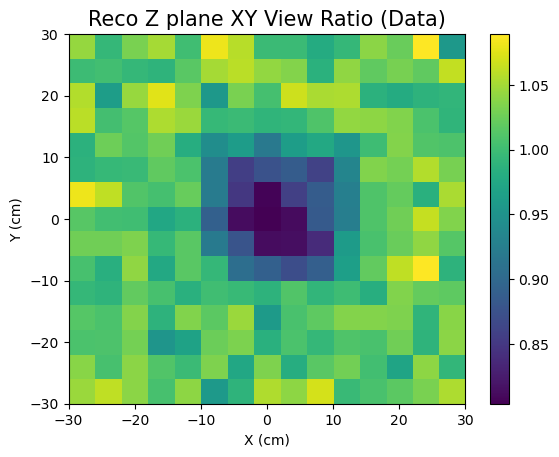

In [14]:
mdfo_lead.reload()
mdfo_lead.keep4by4Events()

mdfo_calib.reload()
mdfo_calib.keep4by4Events()

xx_lead, xx_calib = getSameSizeData(mdfo_lead, mdfo_calib, "xx1")
yy_lead, yy_calib = getSameSizeData(mdfo_lead, mdfo_calib, "yy1")

getRatioPlot([xx_lead,xx_calib],[yy_lead,yy_calib],axes=[-30,30], bins=(15,15))

## Restricted Angles

Within 5 to 10 degrees

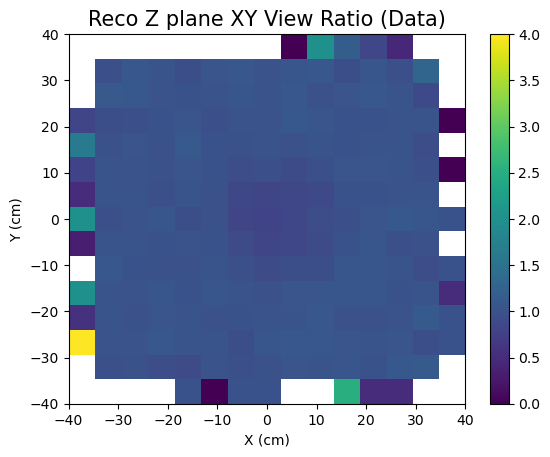

In [58]:
mdfo_lead.reload()
mdfo_lead.keep4by4Events()
mdfo_lead.keepEvents("z_angle", 5, ">=")
mdfo_lead.keepEvents("z_angle", 10, "<=")


mdfo_calib.reload()
mdfo_calib.keep4by4Events()
mdfo_calib.keepEvents("z_angle", 5, ">=")
mdfo_calib.keepEvents("z_angle", 10, "<=")



xx_lead, xx_calib = getSameSizeData(mdfo_lead, mdfo_calib, "xx1")
yy_lead, yy_calib = getSameSizeData(mdfo_lead, mdfo_calib, "yy1")

getRatioPlot([xx_lead,xx_calib],[yy_lead,yy_calib])

Less than 5 degrees.

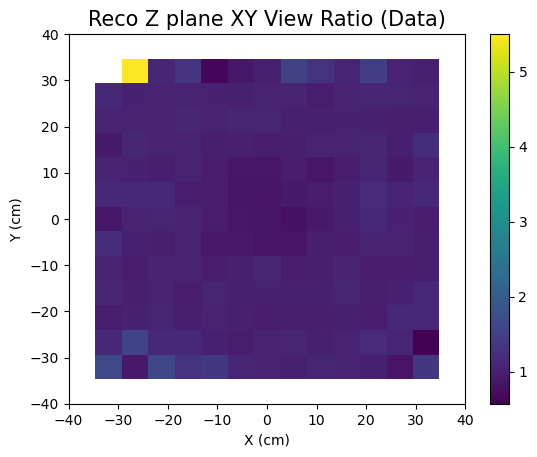

In [64]:
mdfo_lead.reload()
mdfo_lead.keep4by4Events()
mdfo_lead.keepEvents("z_angle", 5, "<=")


mdfo_calib.reload()
mdfo_calib.keep4by4Events()
mdfo_calib.keepEvents("z_angle", 5, "<=")


xx_lead, xx_calib = getSameSizeData(mdfo_lead, mdfo_calib, "xx1")
yy_lead, yy_calib = getSameSizeData(mdfo_lead, mdfo_calib, "yy1")

getRatioPlot([xx_lead,xx_calib],[yy_lead,yy_calib])

5 is weird. Probably sampling a weird space. Less than 8.

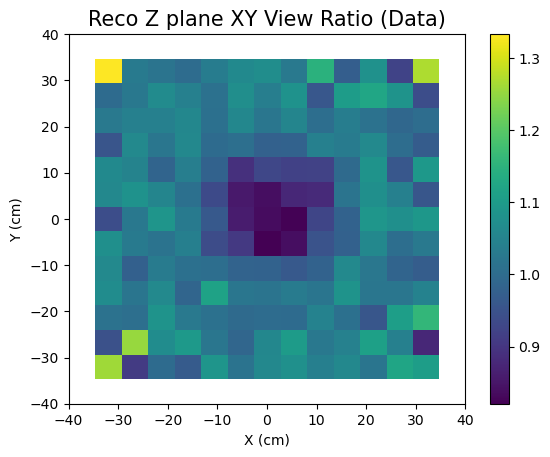

In [63]:
mdfo_lead.reload()
mdfo_lead.keep4by4Events()
mdfo_lead.keepEvents("z_angle", 8, "<=")


mdfo_calib.reload()
mdfo_calib.keep4by4Events()
mdfo_calib.keepEvents("z_angle", 8, "<=")


xx_lead, xx_calib = getSameSizeData(mdfo_lead, mdfo_calib, "xx1")
yy_lead, yy_calib = getSameSizeData(mdfo_lead, mdfo_calib, "yy1")

getRatioPlot([xx_lead,xx_calib],[yy_lead,yy_calib])

## Higher TDC Sum

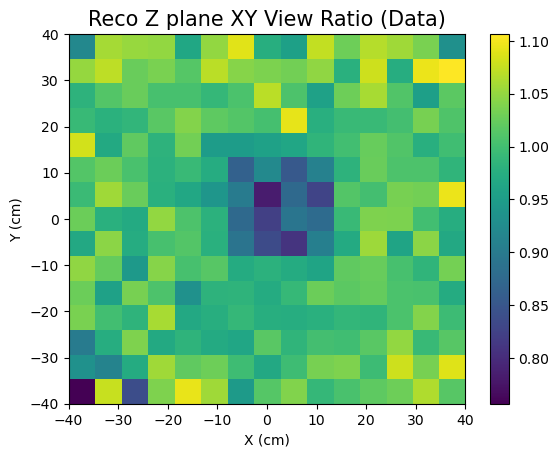

In [66]:
mdfo_lead.reload()
mdfo_lead.keep4by4Events()
mdfo_lead.keepEvents("sumL2",220,">=")

mdfo_calib.reload()
mdfo_calib.keep4by4Events()
mdfo_calib.keepEvents("sumL2",220,">=")


xx_lead, xx_calib = getSameSizeData(mdfo_lead, mdfo_calib, "xx1")
yy_lead, yy_calib = getSameSizeData(mdfo_lead, mdfo_calib, "yy1")

getRatioPlot([xx_lead,xx_calib],[yy_lead,yy_calib])

## Sensible Speeds

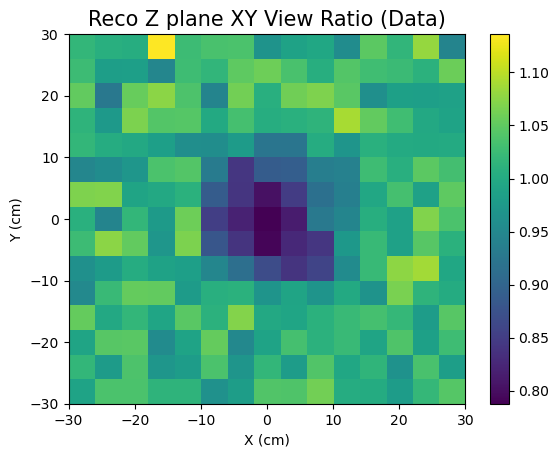

In [9]:
mdfo_lead.reload()
mdfo_lead.keep4by4Events()
mdfo_lead.keepEvents("speed",1,"<")

mdfo_calib.reload()
mdfo_calib.keep4by4Events()
mdfo_calib.keepEvents("speed",1,"<")


xx_lead, xx_calib = getSameSizeData(mdfo_lead, mdfo_calib, "xx1")
yy_lead, yy_calib = getSameSizeData(mdfo_lead, mdfo_calib, "yy1")

getRatioPlot([xx_lead,xx_calib],[yy_lead,yy_calib],axes=[-30,30], bins=(15,15))

### Slower Muons

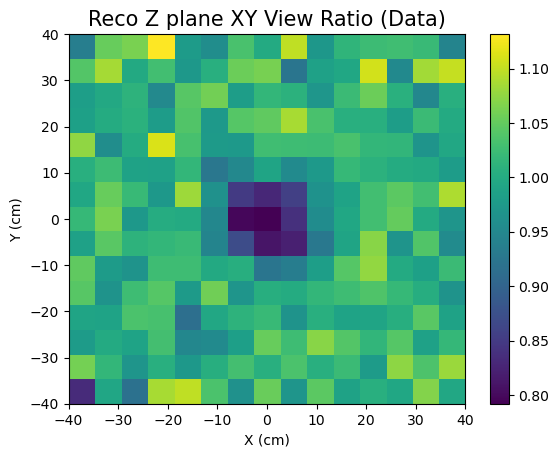

In [70]:
mdfo_lead.reload()
mdfo_lead.keep4by4Events()
mdfo_lead.keepEvents("speed",0.6,"<=")

mdfo_calib.reload()
mdfo_calib.keep4by4Events()
mdfo_calib.keepEvents("speed",0.6,"<=")


xx_lead, xx_calib = getSameSizeData(mdfo_lead, mdfo_calib, "xx1")
yy_lead, yy_calib = getSameSizeData(mdfo_lead, mdfo_calib, "yy1")

getRatioPlot([xx_lead,xx_calib],[yy_lead,yy_calib])

# Top/Bottom Counter Studies

In [39]:
mdfo_lead.reload()
mdfo_calib.reload()

topLead = mdfo_lead.get("TopCounter")
bottomLead = mdfo_lead.get("BottomCounter")

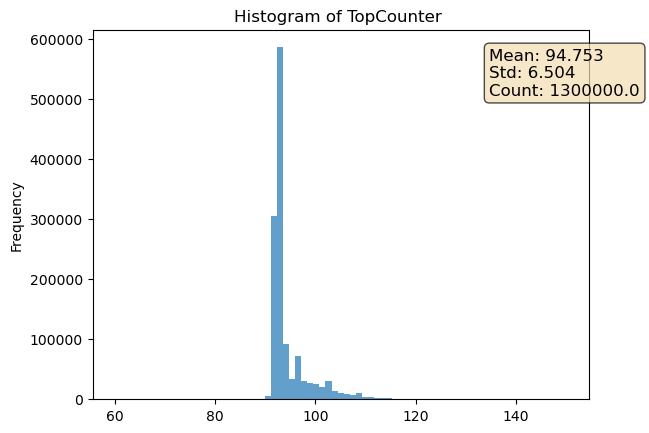

In [56]:
mdfo_lead.getHistogram("TopCounter",range=(60,150),nbins=75)

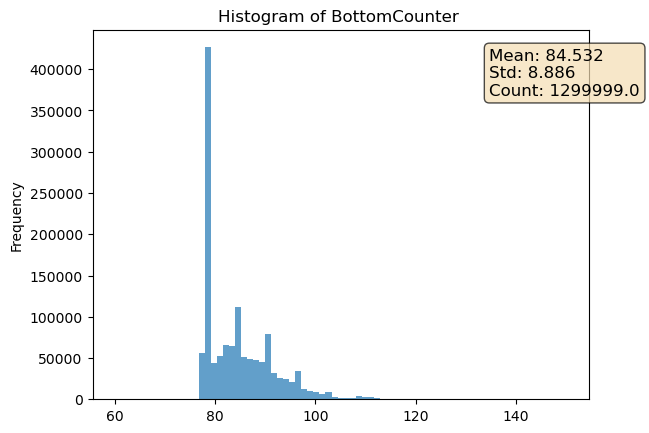

In [52]:
mdfo_lead.getHistogram("BottomCounter",nbins=75,range=(60,150))

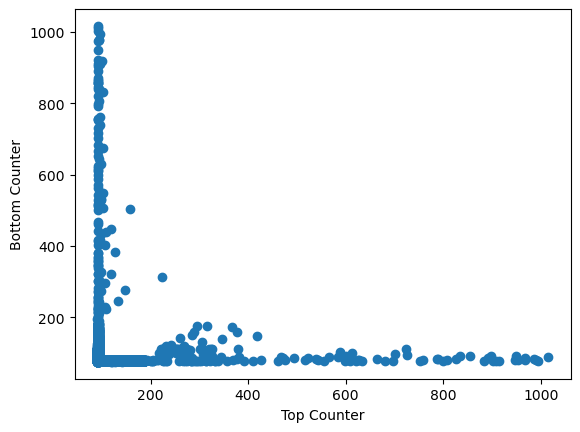

In [58]:
plt.scatter(topLead,bottomLead)
plt.xlabel("Top Counter")
plt.ylabel("Bottom Counter")
plt.show()

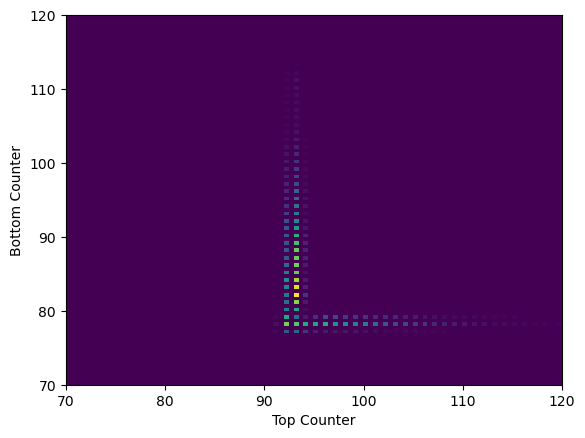

In [57]:
ranges = [(70,120),(70,120)]
bins = 100

plt.hist2d(topLead,bottomLead,bins=bins,range=ranges)
plt.xlabel("Top Counter")
plt.ylabel("Bottom Counter")
plt.show()

# Tomogram through TDC Group

For a given tray, the sum of the TDCs from the two readout channels contains information of muon hit in the orthogonal direction, i.e the other tray in the layer. The sum would be smaller if the hit is closer to the PMT and higher if further away.

Now, I convert these sums to spatial coordinates using which I will generate the tomogram.

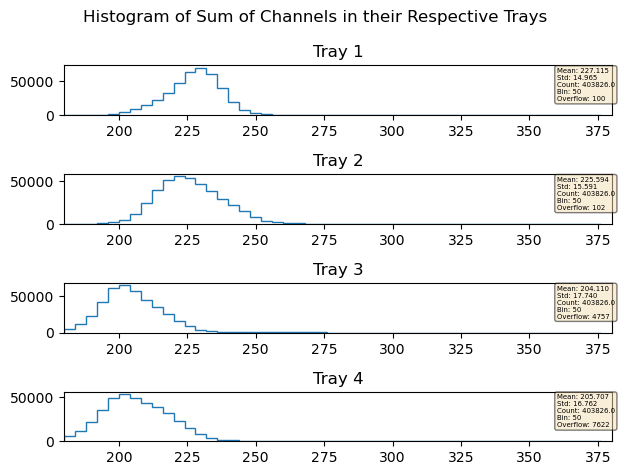

In [71]:
mdfo_lead.getChannelSumPlots()

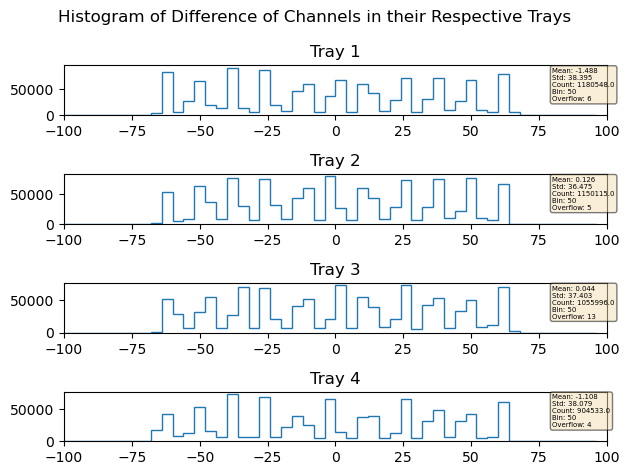

In [29]:
mdfo_lead.getChannelDiffPlots()

## Investigating the SumTDC trends

Need to write a method to investigate TDC trends

In [42]:
mdfo_calib.reload()
mdfo_lead.reload()

mdfo_lead.keepEvents("diffL1",60,">=")

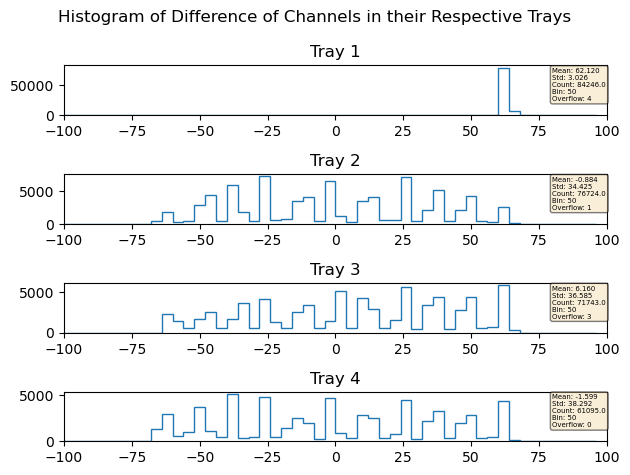

In [43]:
mdfo_lead.getChannelDiffPlots()

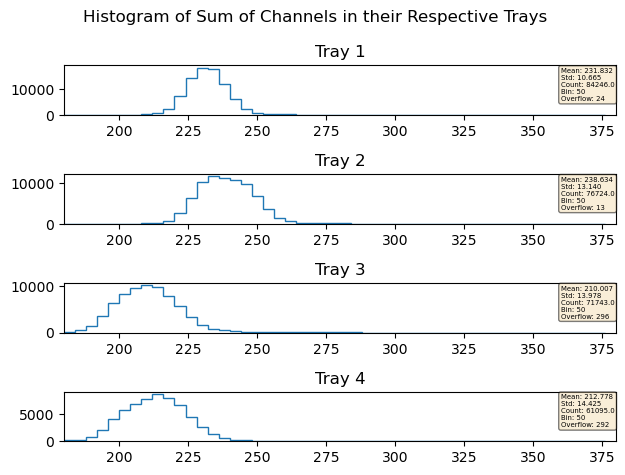

In [44]:
mdfo_lead.getChannelSumPlots()

In [12]:
stats = mdfo_calib.events_df["sumL1"].describe()
mean, std = stats[1], stats[2]

In [20]:
mdfo_calib.reload()
mdfo_lead.reload()

percent = 6
xx_lead = getXatZPlane_sumTDC(mdfo_lead, "sumL1", "sumL3", 42, 165, percent)
yy_lead = getXatZPlane_sumTDC(mdfo_lead, "sumL2", "sumL4", 42, 165, percent)
xx_calib = getXatZPlane_sumTDC(mdfo_calib, "sumL1", "sumL3", 42, 165, percent)
yy_calib = getXatZPlane_sumTDC(mdfo_calib, "sumL2", "sumL4", 42, 165, percent)

mdfo_lead.events_df["xx2"] = xx_lead
mdfo_lead.events_df["yy2"] = yy_lead

mdfo_calib.events_df["xx2"] = xx_calib
mdfo_calib.events_df["yy2"] = yy_calib

diff1:  86.90434687125614 
diff2:  104.47901454318028
diff1:  89.26802556340203 
diff2:  101.19632936544863
diff1:  85.8982477205681 
diff2:  97.46071642386917
diff1:  86.65366636517393 
diff2:  94.04958673824422


In [21]:
mdfo_lead.show()

,Unnamed: 0,event_num,event_time,deadtime,l1hit,l2hit,l3hit,l4hit,r1hit,r2hit,...,theta_x2,theta_y2,z_angle,SmallCounter,Run_Num,xx,yy,speed,xx2,yy2
0,0,0,0,0,1,0,1,1,0,0,...,-24.429218,-134.380326,NaN,NaN,410,NaN,NaN,NaN,NaN,NaN
1,1,1,510238,0,1,1,1,0,1,1,...,NaN,NaN,NaN,NaN,410,14.764119,NaN,NaN,175.918683,NaN
2,2,2,680128,0,1,1,1,1,1,1,...,-inf,-0.000000,6.464752,NaN,410,-18.990826,-14.251543,3.692686,161.340210,146.865882
3,3,3,1190113,0,1,1,1,0,1,1,...,NaN,NaN,NaN,NaN,410,-13.148333,NaN,NaN,151.947750,NaN
4,4,4,1500428,0,1,1,1,1,1,1,...,-18.455272,-177.879054,5.185096,NaN,410,6.296684,0.842881,2.763211,159.012255,152.279663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1299995,1299995,1299995,415072964999,0,1,1,1,1,1,1,...,-0.981846,-3343.503246,16.958188,NaN,422,-37.292360,14.723278,0.234857,173.130343,165.344747
1299996,1299996,1299996,415073134888,0,1,1,1,1,1,1,...,-41.120440,-79.833930,2.626992,NaN,422,-12.687742,19.308536,0.612178,172.702726,163.871534
1299997,1299997,1299997,415073565015,0,1,1,1,1,0,0,...,inf,0.000000,NaN,NaN,422,NaN,NaN,NaN,NaN,NaN
1299998,1299998,1299998,415073675247,0,1,1,1,0,1,1,...,NaN,NaN,NaN,NaN,422,-2.350427,NaN,NaN,156.684300,NaN


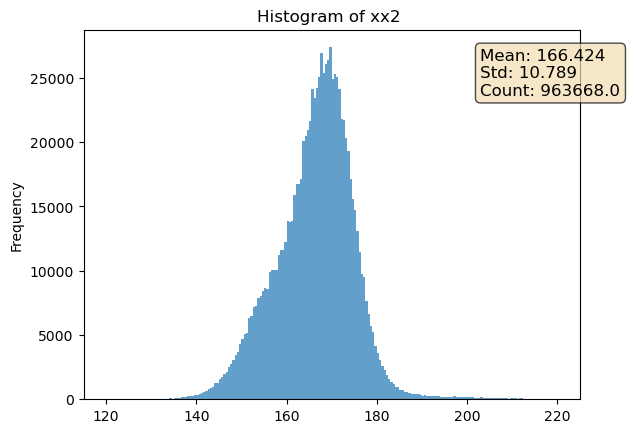

In [28]:
mdfo_calib.getHistogram("xx2",range=(120,220))

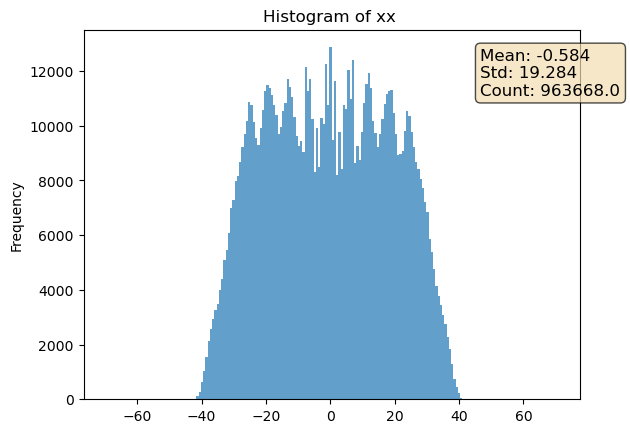

In [25]:
mdfo_calib.getHistogram("xx")

# Time of Photon Flight

The time (TDC) of the photon path should be as follows:

$$ \frac{(sumTDC + diffTDC)}{2} - TDC_L $$

Here, $TDC_L$ is the TDC time taken by the signal from the PMT to reach the DAQ. Since $TDC_L$ is not being measured directly, we cannot use this equation directly.

Just looking at $ \frac{(sumTDC + diffTDC)}{2} $ distribution for fun.

In [30]:
mdfo_lead.events_df["ts1"] = (mdfo_lead.get("sumL1")+mdfo_lead.get("diffL1"))/2 

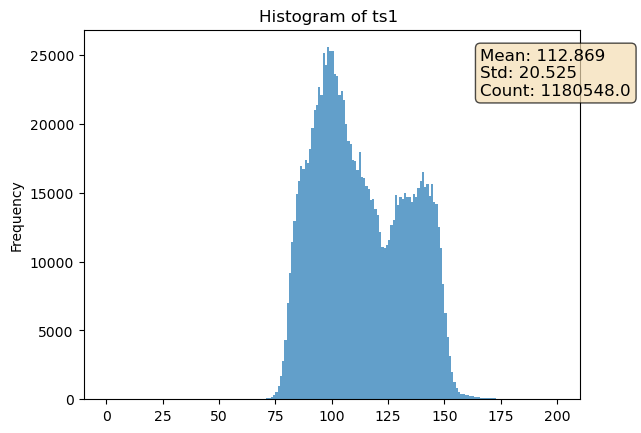

In [31]:
mdfo_lead.getHistogram("ts1",range=(0,200))

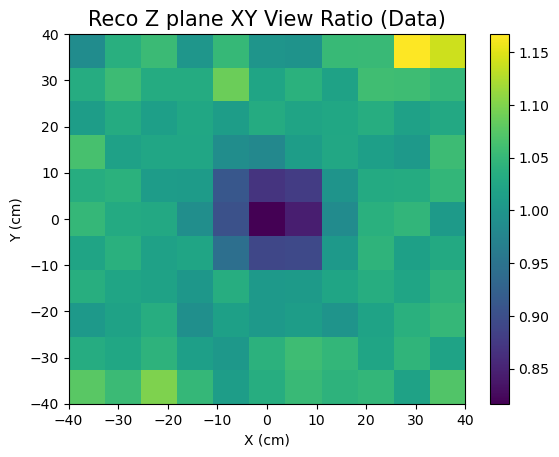

In [38]:
mdfo_lead.reload()
mdfo_calib.reload()

xx_lead, xx_calib = getSameSizeData(mdfo_lead, mdfo_calib, "xx")
yy_lead, yy_calib = getSameSizeData(mdfo_lead, mdfo_calib, "yy")

getRatioPlot([xx_lead,xx_calib],[yy_lead,yy_calib],bins=(11,11))